In [1]:
# Imports
from __future__ import division
import numpy as np
import os
import glob
from PIL import Image
from random import *
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# Create sentence writer mapping
#Dictionary with form and writer mapping
d = {}
with open('/content/drive/MyDrive/Handwriting plagiarism/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer

In [4]:
# Create array of file names and corresponding target writer names
tmp = []
target_list = []
path_to_files = os.path.join('/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u', '*')
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)

['/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-00.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-01.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-02.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-03.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s01-00.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s01-01.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s01-02.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s01-03.png']
['/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-00.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-01.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-02.png'
 '/conten

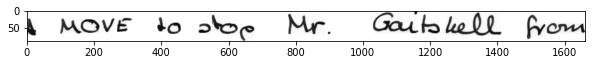

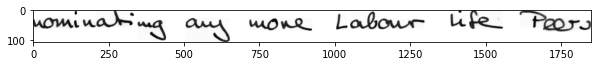

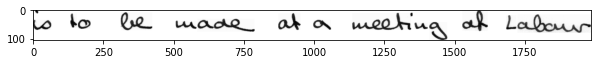

In [5]:
# Visualizing the data
# for dirname, _, filenames in os.walk('/content/drive/MyDrive/Handwriting plagiarism/dataset'):
# path_to_files = os.path.join(filename, '*')
for filename in img_files[:3]:
      # print(filename)
      # for fn in os.listdir(filename):
      # f = os.path.join(filename, fn.decode("utf-8"))
      print(img_files)
      img=mpimg.imread(filename)
      plt.figure(figsize=(10,10))
      plt.imshow(img, cmap ='gray')

In [6]:
# Label Encode writer names for one hot encoding later
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-00.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-01.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-02.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s00-03.png'
 '/content/drive/MyDrive/Handwriting plagiarism/dataset/a01/a01-000u/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [7]:
#split into test train and validation in ratio 4:1:1

from sklearn.model_selection import train_test_split
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(5,) (1,) (2,)
(5,) (1,) (2,)


In [8]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

In [9]:
# Generate data for training and validation
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [10]:
# Build a neural network in Keras

# Function to resize image to 56x56
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
# model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 115, 115, 1)      0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 58, 58, 32)        832       
                                                                 
 activation (Activation)     (None, 58, 58, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 29, 29, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 29, 29, 64)        0         
                                                        

In [21]:
# Train the model 

nb_epoch = 5

samples_per_epoch = 25
nb_val_samples = 15


#save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

#Model fit generator
history_object = model.fit_generator(train_generator, steps_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00001: saving model to checkpoint2/check-01-0.0000.hdf5
25/25 [==============================] - 14s 569ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00002: saving model to checkpoint2/check-02-0.0000.hdf5
25/25 [==============================] - 14s 567ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00003: saving model to checkpoint2/check-03-0.0000.hdf5
25/25 [==============================] - 14s 568ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
25/25 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 

## Test model performance on the Test Set

1. Accuracy on test set
2. Samples predicted to be from the same writer

In [12]:
# Load save model and use for prediction on test set
# model.load_weights('low_loss.hdf5')
# scores = model.evaluate_generator(test_generator,5) 
# print("Accuracy = ", scores[1])

In [13]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

    # print(cur_width, cur_height)
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
    now_width = imresize.size[0]
    now_height = imresize.size[1]
    # Generate crops of size 113x113 from this resized image and keep random 10% of crops

    avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

    # Pick random x%
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    #convert to float and normalize
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

(401, 113, 113, 1)


In [14]:
# Play with results from model 
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

13/13 [==============================] - 0s 9ms/step
(401, 50)
401


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


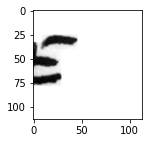

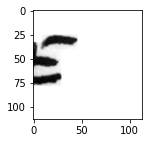

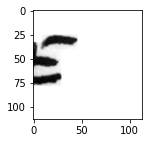

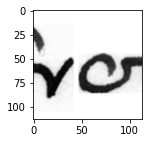

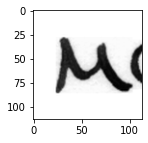

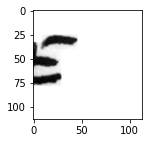

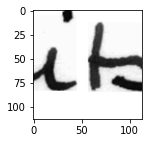

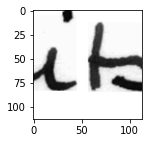

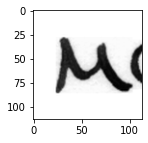

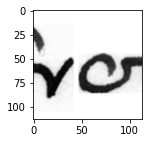

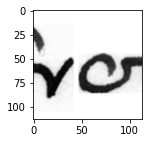

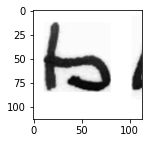

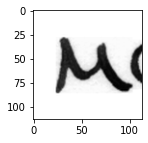

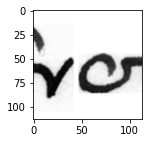

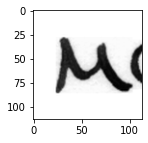

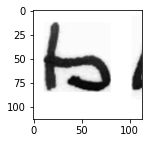

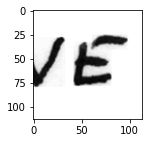

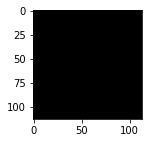

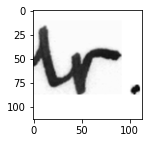

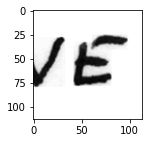

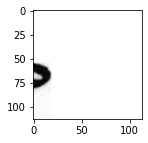

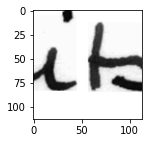

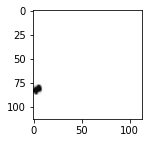

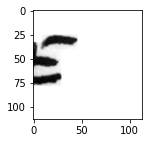

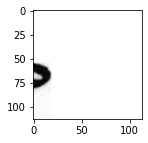

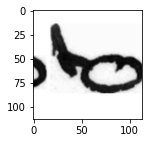

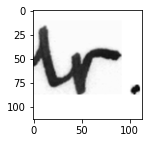

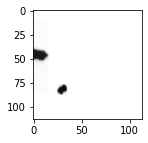

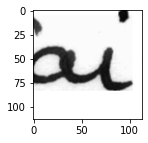

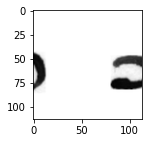

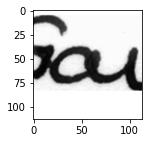

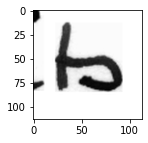

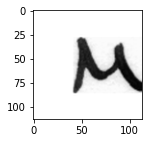

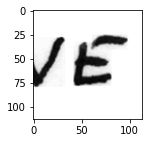

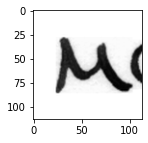

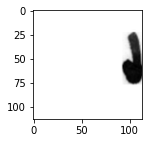

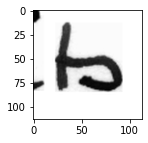

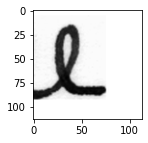

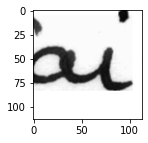

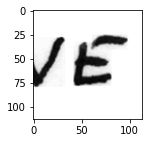

In [15]:
writer_number = 0
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

In [17]:
acc=history_object.history['accuracy']
loss=history_object.history['loss']
val_acc=history_object.history['val_accuracy']
val_loss=history_object.history['val_loss']

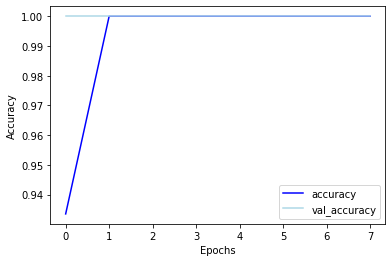

Accuracy:  1.0
Validation Accuracy:  1.0


In [19]:
import matplotlib.pyplot as plt
plt.plot(acc,'b', label='accuracy')
plt.plot(val_acc,'lightblue', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("Accuracy: ", history_object.history['accuracy'][-1])
print("Validation Accuracy: ",history_object.history['val_accuracy'][-1])